In [7]:
import numpy as np
import matplotlib.pyplot as plt

from pymoo.util.ref_dirs import get_reference_directions

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.moead import MOEAD

from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.termination.default import DefaultMultiObjectiveTermination

import itertools
from quantify_core.data.handling import (
    load_dataset,
    set_datadir,
    default_datadir,
)

In [8]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
tuid = "20241207-194048-547-5c7816"
dataset = load_dataset(tuid)
dataset

<xarray.Dataset> Size: 198kB
Dimensions:  (dim_0: 2744)
Coordinates:
    x0       (dim_0) float64 22kB 4.8e-08 1.04e-07 1.64e-07 ... 7.4e-07 7.96e-07
    x1       (dim_0) float64 22kB 7.37e+09 7.37e+09 ... 7.42e+09 7.42e+09
    x2       (dim_0) float64 22kB 0.005 0.005 0.005 0.005 ... 0.07 0.07 0.07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 22kB 0.5118 0.5128 0.5101 ... 0.7327 0.7516 0.5369
    y1       (dim_0) float64 22kB 0.511 0.5122 0.5066 ... 0.777 0.8044 0.5442
    y2       (dim_0) float64 22kB 0.5126 0.5181 0.5101 ... 0.8332 0.8606 0.5499
    y3       (dim_0) float64 22kB 0.5119 0.5083 0.5136 ... 0.588 0.5898 0.5166
    y4       (dim_0) float64 22kB 0.5 0.5063 0.5 0.503 ... 0.6812 0.7066 0.6645
    y5       (dim_0) float64 22kB 0.5039 0.5016 0.5063 0.5 ... 0.637 0.6667 0.5
Attributes:
    tuid:                             20241207-194048-547-5c7816
    name:                             Single-shot readout vs. pulse duration,...
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [6]:
for key in dataset.keys():
    print(key)

y0
y1
y2
y3
y4
y5


In [4]:
def fidelityEstimate(point, frequency, amplitude, duration, fidelity):
    # Get unique values of frequency, amplitude, and duration
    unique_freq = np.unique(frequency)
    unique_ampl = np.unique(amplitude)
    unique_dur = np.unique(duration)
    
    # Get the closest 3 unique frequencies, amplitudes, and durations
    dFreq = np.abs(unique_freq - point[0])
    dAmpl = np.abs(unique_ampl - point[1])
    dDur = np.abs(unique_dur - point[2])
    
    freqArgs = np.argsort(dFreq)[:2]
    amplArgs = np.argsort(dAmpl)[:2]
    durArgs = np.argsort(dDur)[:2]
    
    x_coor = unique_freq[freqArgs]
    y_coor = unique_ampl[amplArgs]
    z_coor = unique_dur[durArgs]
    
    # Sort the coordinates
    sortedX = np.sort(x_coor)
    sortedY = np.sort(y_coor)
    sortedZ = np.sort(z_coor)
    
    # Calculate differences
    dx = np.diff(sortedX)
    dy = np.diff(sortedY)
    dz = np.diff(sortedZ)
    
    fidelities = []
    
    # Iterate through all combinations of (frequency, amplitude, duration)
    for i in itertools.product(sortedX, sortedY, sortedZ):
        temp1 = np.where(i[0] == frequency)
        temp2 = np.where(i[1] == amplitude)
        temp3 = np.where(i[2] == duration)
        arg = np.intersect1d(np.intersect1d(temp1, temp2), temp3)
        fidelities.append(fidelity[arg])
    
    fidelities = np.array(fidelities)
    
    # Reshape fidelities into a 2x2x2 grid for interpolation
    fidelity_matrix = fidelities.reshape((2, 2, 2))
    
    # 3D Bilinear interpolation formula
    result = (fidelity_matrix[0, 0, 0] * (sortedX[1] - point[0]) * (sortedY[1] - point[1]) * (sortedZ[1] - point[2]) +
              fidelity_matrix[1, 0, 0] * (point[0] - sortedX[0]) * (sortedY[1] - point[1]) * (sortedZ[1] - point[2]) +
              fidelity_matrix[0, 1, 0] * (sortedX[1] - point[0]) * (point[1] - sortedY[0]) * (sortedZ[1] - point[2]) +
              fidelity_matrix[1, 1, 0] * (point[0] - sortedX[0]) * (point[1] - sortedY[0]) * (sortedZ[1] - point[2]) +
              fidelity_matrix[0, 0, 1] * (sortedX[1] - point[0]) * (sortedY[1] - point[1]) * (point[2] - sortedZ[0]) +
              fidelity_matrix[1, 0, 1] * (point[0] - sortedX[0]) * (sortedY[1] - point[1]) * (point[2] - sortedZ[0]) +
              fidelity_matrix[0, 1, 1] * (sortedX[1] - point[0]) * (point[1] - sortedY[0]) * (point[2] - sortedZ[0]) +
              fidelity_matrix[1, 1, 1] * (point[0] - sortedX[0]) * (point[1] - sortedY[0]) * (point[2] - sortedZ[0])) / (dx * dy * dz)
    
    return result

def two_qubit_landscape_simulation(point, dataset, fid):
    """
    Function that returns the requested fidelity, fidelity must be:
        1) "Average assignment fidelity"
        2) "QND fidelity"
        3) "QND pi fidelity
    
    The function takes as input:
        - point [frequency_q1, amplitude_q1, duration_q1, frequency_q2, amplitude_q2, duration_q2]: the point in the landscape to be evaluated
        - dataset [-]: dataset containing the data from measurements
        - fid [str]: the fidelity to be returned
    
    Returns:
        - A tuple containing fid values for both qubits at the datapoint
    """
    fidelity_types = ["Average assignment fidelity", "QND fidelity", "QND pi fidelity"]
    assert fid in fidelity_types, f"Choose one of the following: {fidelity_types}"

    if fid == "Average assignment fidelity":
        fidelity = dataset.y0.data

    elif fid == "QND fidelity":
        fidelity = dataset.y4.data

    else:
        fidelity = dataset.y5.data

    frequency = dataset.x1.data
    amplitude = dataset.x2.data
    duration = dataset.x0.data

    freq_bounds = [np.min(frequency), np.max(frequency)]
    ampl_bounds = [np.min(amplitude), np.max(amplitude)]
    dur_bounds = [np.min(duration), np.max(duration)]
        
    assert freq_bounds[0] <= point[0] <= freq_bounds[1], f"Frequency of qubit 1 should be in {freq_bounds}"
    assert ampl_bounds[0] <= point[1] <= ampl_bounds[1], f"Amplitude of qubit 1 should be in {ampl_bounds}" 
    assert dur_bounds[0]  <= point[2] <= dur_bounds[1],  f"Duration of qubit 1 should be in {dur_bounds}" 
    assert freq_bounds[0] <= point[3] <= freq_bounds[1], f"Frequency of qubit 2 should be in {freq_bounds}"
    assert ampl_bounds[0] <= point[4] <= ampl_bounds[1], f"Amplitude of qubit 2 should be in {ampl_bounds}" 
    assert dur_bounds[0]  <= point[5] <= dur_bounds[1],  f"Duration of qubit 2 should be in {dur_bounds}" 
    
    F1 = fidelityEstimate(point[:3], frequency, amplitude, duration, fidelity)[0]
    F2 = fidelityEstimate(point[3:], frequency, amplitude, duration, fidelity)[0]

    return F1, F2, fid

#Objective functions need to be vectorized
def objective(points, dataset, fid):
    obj_1 = []
    obj_2 = []
    for point in points:
        objective1 = two_qubit_landscape_simulation(point,dataset,fid)[0]
        obj_1.append(objective1)
        
        objective2 = two_qubit_landscape_simulation(point,dataset,fid)[1]
        obj_2.append(objective2)
    return np.log(1-np.array(obj_1)), np.log(1-np.array(obj_2))



In [5]:
class pareto_problem_1(Problem):
    """
    A bi-objective problem for optimizing two-qubit fidelities.
    """

    def __init__(self, dataset, fid, n_qubits):
        # Define bounds from dataset
        frequency = dataset.x1.data
        amplitude = dataset.x2.data
        duration = dataset.x0.data

        freq_bounds = [np.min(frequency), np.max(frequency)]
        ampl_bounds = [np.min(amplitude), np.max(amplitude)]
        dur_bounds = [np.min(duration), np.max(duration)]

        # Decision vector: [fq1, amp1, dur1, fq2, amp2, dur2]
        xl = [freq_bounds[0], ampl_bounds[0], dur_bounds[0],
              freq_bounds[0], ampl_bounds[0], dur_bounds[0]]
        xu = [freq_bounds[1], ampl_bounds[1], dur_bounds[1],
              freq_bounds[1], ampl_bounds[1], dur_bounds[1]]

        super().__init__(
            n_var=3*n_qubits,      
            n_obj=2,    
            n_ieq_constr=0,
            xl=xl,
            xu=xu
        )

        self.dataset = dataset
        self.fid = fid
        self.n_qubits = n_qubits

    def _evaluate(self, x, out):
        _f1, _f2 = objective(x, self.dataset, self.fid)
        y = np.column_stack([_f1, _f2])
        out["F"] = np.array(y)

In [7]:
problem = pareto_problem_1(dataset, fid="Average assignment fidelity", n_qubits=2)

n_pop = 100
algorithm = NSGA2(
    pop_size=n_pop,
    n_offsprings=n_pop,
    sampling=FloatRandomSampling(),
    eliminate_duplicates=True,
)

n_generations = [10, 25, 50, 100]
results = []

for n_gen in n_generations:
    res = minimize(
        problem,
        algorithm,
        ("n_gen", n_gen),
        save_history=True,
        verbose=True,
    )
    results.append(res)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      2 |             - |             -
     2 |      200 |      4 |  0.0072334534 |         ideal
     3 |      300 |      2 |  0.0929683463 |         ideal
     4 |      400 |      4 |  0.0347394683 |         ideal
     5 |      500 |      4 |  0.0249913894 |         ideal
     6 |      600 |      5 |  0.0018682024 |             f
     7 |      700 |     10 |  0.0048631225 |         ideal
     8 |      800 |      9 |  0.3993452810 |         nadir
     9 |      900 |     11 |  0.0481568099 |         ideal
    10 |     1000 |     14 |  0.0053546301 |         ideal
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      7 |             - |             -
     2 |      200 |      5 |  0.2202773790 |         nadir
     3 |      300 |      7 |  0.0506052956 |         ideal
     4 |      400 |      9 |  0.0808743354 |         ideal
     5 |      500 |      9 |  0.0841035808 |            

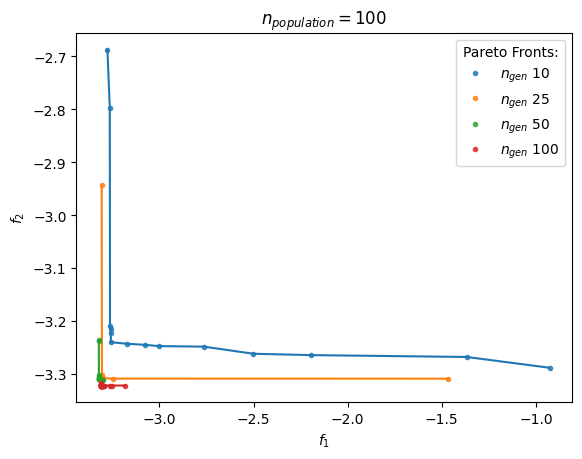

In [14]:
colors = ['C0', 'C1', 'C2', 'C3']

for i, result in enumerate(results):
    result_1 = result.F
    order = np.argsort(result_1[:, 0])
    # if i == 0:
    plt.plot(
        result_1[order, 1], result_1[order, 0], 'o',
        color=colors[i],alpha=0.8, label=fr"$n_{{gen}}$ {n_generations[i]}", markersize=3
        )
    plt.plot(result_1[order, 1], result_1[order, 0], color=colors[i])

plt.legend(frameon=True, title=r"Pareto Fronts:")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.title(fr"$n_{{population}} = {n_pop}$")
plt.show()

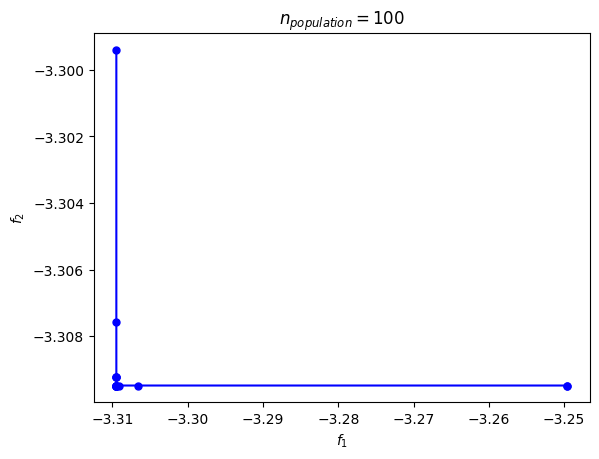

In [17]:
data = np.load('data_Pareto/20250625-112526-550074-NSGAII-Pareto data.npz')
result_1 = data['F']
order = np.argsort(result_1[:, 0])
plt.plot(result_1[order, 1], result_1[order, 0], 'o', markersize=5, c='blue' )
plt.plot(result_1[order, 1], result_1[order, 0], c='blue')
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.title(fr"$n_{{population}} = {100}$")
plt.show()